## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

We plotted the clusters for our train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=1) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

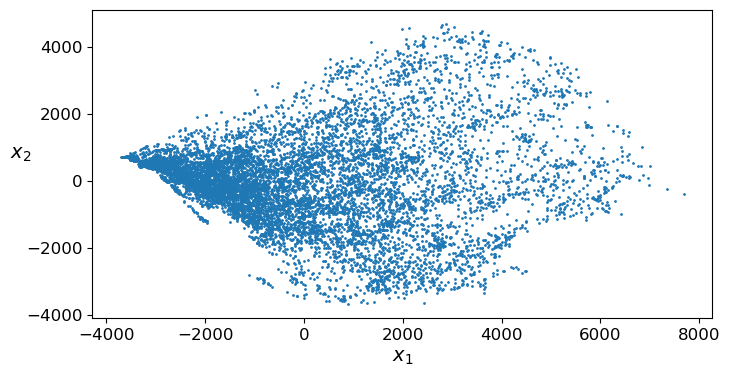

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train)

plt.figure(figsize=(8, 4))
plot_clusters(X_pca1)
plt.show()

We then preprocessed the train dataset and plotted the clusters again.

In [8]:
# Created a list to store the labels that have less number of pictures
less_class_labels = [0, 5, 6, 7, 8, 9]

data_list = []
for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]
    image_data = row.values.reshape(48, 48)

    if label in less_class_labels:
        data_list.append((image_data, label))

subset_dataset = np.array(data_list, dtype=object)

print(subset_dataset.shape)

num_images_per_label = {label: np.sum(subset_dataset[:, 1] == label) for label in less_class_labels}

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

(1830, 2)
Label 0: 210 images
Label 5: 210 images
Label 6: 360 images
Label 7: 240 images
Label 8: 540 images
Label 9: 270 images


In [9]:
def add_noise(feature_vector, noise_level=0.01):
    noise = np.random.normal(0, noise_level, feature_vector.shape)
    noisy_vector = feature_vector + noise
    return noisy_vector

In [10]:
def introduce_perturbations(feature_vector, perturbation_level=0.02):
    min_value = np.min(feature_vector)
    max_value = np.max(feature_vector)
    perturbations = np.random.uniform(-perturbation_level, perturbation_level, feature_vector.shape)
    perturbed_vector = feature_vector + perturbations * (max_value - min_value)
    return perturbed_vector

In [11]:
from scipy.stats.mstats import winsorize
x_train = np.array(x_train)

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=1.7, beta = 90)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

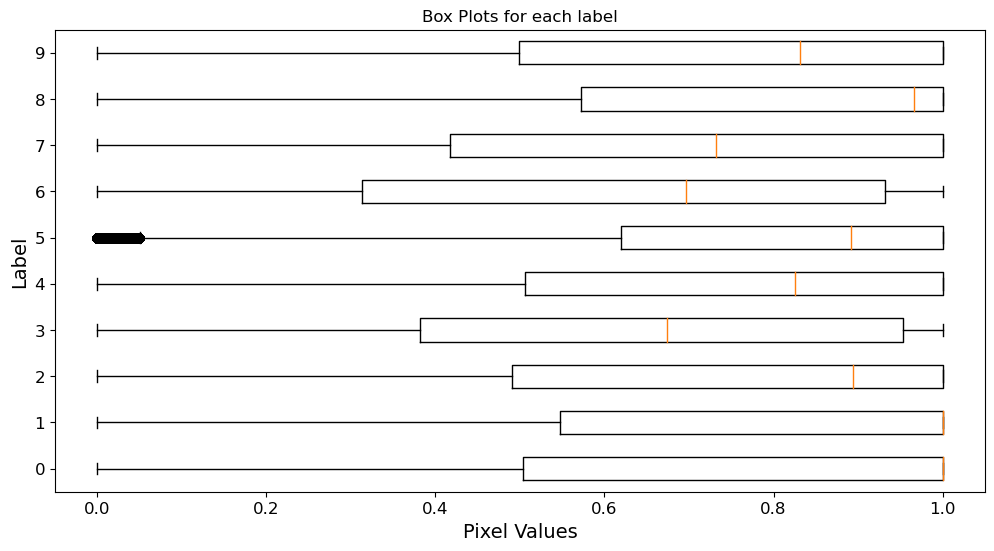

Label 0: 210 images
Label 1: 2220 images
Label 2: 2250 images
Label 3: 1410 images
Label 4: 1980 images
Label 5: 210 images
Label 6: 360 images
Label 7: 240 images
Label 8: 540 images
Label 9: 270 images


In [12]:
label_images = {}

num_images_per_label = {}

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]  
    image_data = row.values.reshape(-1, 48, 48) 

    if label not in label_images:
        label_images[label] = []
    
    label_images[label].append(image_data)

    num_images_per_label[label] = len(label_images[label])

box_data = np.array(list(label_images.values()), dtype=object)

labels = list(label_images.keys())

plt.figure(figsize=(12, 6))
plt.boxplot(box_data, labels=labels, vert=False)
plt.title("Box Plots for each label")
plt.xlabel("Pixel Values")
plt.ylabel("Label")
plt.show()

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

In [13]:
print(x_train.shape)
print(y_train.shape)

augmented_data = []
new_augmented_data = []
labels_for_train = []
for data, label in subset_dataset:
    noisy_vector = add_noise(data, noise_level=0.01)  
    perturbed_vector = introduce_perturbations(data, perturbation_level=0.02)  
    
        # Append the original and augmented data with their respective labels
    augmented_data.append((data, label))
    augmented_data.append((noisy_vector, label))
    augmented_data.append((perturbed_vector, label))

# Convert the appended data to a NumPy array
for image_vectors, label_col in augmented_data:
    new_augmented_data.append(image_vectors)
    labels_for_train.append(label_col)

new_augmented_data = np.array(new_augmented_data)
labels_for_train = np.array(labels_for_train)

new_labels = labels_for_train.reshape(-1, 1)

new_augmented_data = new_augmented_data.reshape(new_augmented_data.shape[0], -1)

print(new_augmented_data.shape)
print(new_labels.shape)
if new_augmented_data.shape[1] == x_train.shape[1]:
    x_train = np.vstack((x_train, new_augmented_data))
    y_train = np.concatenate((y_train, new_labels))
else:
    print("Number of columns in appended_data doesn't match x_train.")

print(x_train.shape)
print(y_train.shape)

(9690, 2304)
(9690, 1)
(5490, 2304)
(5490, 1)
(15180, 2304)
(15180, 1)


In [14]:
rotation_angle = 15
scale_factor = 1.2

rotated_images = []

for image in x_train:
    image = image.reshape(48, 48)  
    rotated_image = cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), rotation_angle, scale_factor), (image.shape[1], image.shape[0]))
    rotated_images.append(rotated_image)

x_train = np.asarray(rotated_images)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(15180, 2304)

In [15]:
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Additional Pre processing
def preprocess_data(data):
    preprocessed_images = []
    
    for image in data:
        # Reshaping the image to its original shape
        image = image.reshape(48, 48)
        
        # Apply Gaussian blur to reduce noise
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # Apply sharpening filter to enhance image details
        sharpened_image = cv2.filter2D(blurred_image, -1, np.array([[-1, -1, -1],
                                                                    [-1,  9, -1],
                                                                    [-1, -1, -1]]))
        
        # Standardize pixel values using StandardScaler
        scaler = StandardScaler()
        standardized_image = scaler.fit_transform(sharpened_image)
        
        # Append the preprocessed image to the list
        preprocessed_images.append(standardized_image)
    
    preprocessed_data = np.asarray(preprocessed_images)
    
    # Reshape the data back to the flattened format
    preprocessed_data = preprocessed_data.reshape(preprocessed_data.shape[0], -1)
    
    return preprocessed_data

x_train = preprocess_data(x_train)
print(x_train.shape)

(15180, 2304)


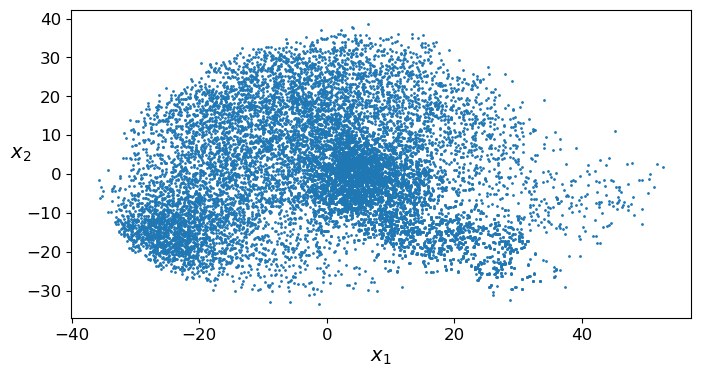

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train)

plt.figure(figsize=(8, 4))
plot_clusters(X_pca2)
plt.show()

We train a K-Means clusterer on the dataset.

In [17]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_train)
y_pred = kmeans.predict(x_train)
kmeans_cluster_labels = kmeans.labels_

/Users/fayazbadubhai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
y_pred

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [19]:
y_pred is kmeans.labels_

False

In [20]:
kmeans.cluster_centers_

array([[-1.69427006, -1.49909577, -1.09822239, ..., -0.84565264,
        -1.35770579, -1.45399957],
       [-1.2428934 , -0.97413158, -0.47286143, ..., -0.49365153,
        -0.85742676, -1.02490679],
       [-1.32178908, -1.07871723, -0.61762894, ..., -0.56173406,
        -0.90501651, -1.06735924],
       [-1.79062458, -1.36710364, -0.16836003, ..., -0.11563299,
        -0.96310659, -1.21199065],
       [-2.13579617, -1.83713085, -0.90479196, ..., -0.60031589,
        -1.31649524, -1.39485389]])

In [21]:
kmeans.labels_

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [23]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(y_train.ravel(), kmeans_cluster_labels)
print("Adjusted Rand Index:", ari_score)

Adjusted Rand Index: 0.09083514840632484


In [ ]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

### 3) Running Naïve Bayes Classifier on Train Dataset

#### 3.1) Categorical Naïve Bayes Classifier

In [ ]:
from sklearn.naive_bayes import CategoricalNB

cnb_x_train = np.asarray(cnb_x_train)
xtrain_images = cnb_x_train.reshape(cnb_x_train.shape[0], -1)
cnb_y_train = np.asarray(cnb_y_train).ravel()
clf = CategoricalNB()
clf.fit(xtrain_images,cnb_y_train)

predictions = clf.predict(cnb_x_train)

#### 3.2) Gaussian Naïve Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()
clf2 = GaussianNB()
clf2.fit(xtrain_images, y_train)

predictions_gb = clf2.predict(x_train)

### 4) Evaluation Metrics for the Naïve Bayes Classifier on Dataset

#### 4.1) Categorical Naïve Bayes Classifier

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(cnb_y_train, predictions)

print(report)

In [ ]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(cnb_y_train, predictions)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(cnb_y_train, predictions)
confusion_matrix

In [ ]:
#Reference : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,  fmt='.2%', cmap='Blues')

In [ ]:
tp = confusion_matrix.diagonal()
fn = np.sum(confusion_matrix, axis=1) - tp
fp = np.sum(confusion_matrix, axis=0) - tp
tn = np.sum(confusion_matrix) - (tp + fn + fp)

# TP Rate (Sensitivity or Recall)
tp_rate = tp / (tp + fn)

# FP Rate
fp_rate = fp / (fp + tn)

for class_label, tp, fp in zip(range(len(tp_rate)), tp_rate, fp_rate):
    print(f"Class {class_label}: \nTP Rate = {tp}, \nFP Rate = {fp}")

In [ ]:
specificity = []
unique_labels = np.unique(cnb_y_train)

for i in range(len(unique_labels)):
    true_negative = np.sum(confusion_matrix) - np.sum(confusion_matrix[i, :]) - np.sum(confusion_matrix[:, i]) + confusion_matrix[i, i]
    total_negative = np.sum(confusion_matrix) - np.sum(confusion_matrix[i, :])
    print(f'Label {unique_labels[i]} specificity: {true_negative / total_negative}')

In [ ]:
from sklearn.metrics import recall_score

sensitivity = recall_score(cnb_y_train, predictions, average=None)
for i in range(len(unique_labels)):
    print(f'Label {unique_labels[i]} sensitivity: {sensitivity[i]}')

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities = clf.predict_proba(cnb_x_train)
roc_auc_scores = []
plt.figure(figsize=(8, 6))

for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve((cnb_y_train == unique_labels[i]).astype(int), probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### Evaluation Using Cross-Validation

We had manually created our own cross-validation which divides our dataset into folds and iteratively trains and evaluates our Categorical NB classifier on each fold. We also tried the cross-validation technique of sklearn module.

But we found that we kept having an error with the cross-validation even though we achieved high accuracy. There were 2 reasons:

1) Our dataset only had Numeric/Continuous data and had no categorical data. We later discovered the actual purpose of a Categorical NB Classifier through this evaluation, that is Categorical NB can only be used categorical data like gender, color, etc.

In [ ]:
data_types = pd.DataFrame(cnb_x_train).dtypes
numeric_columns = data_types[data_types.apply(lambda x: pd.api.types.is_numeric_dtype(x))].index
categorical_columns = data_types[data_types.apply(lambda x: not pd.api.types.is_numeric_dtype(x))].index

print("Numeric (Continuous) Columns:")
print(numeric_columns)

print("\nCategorical Columns:")
print(categorical_columns)

2. The 2nd reason is listed below:

In [ ]:
x_num_features = cnb_x_train.shape[1]
num_features_expected = len(clf.n_categories_)
list_features = clf.n_categories_
print(f"The CategoricalNB model takes {x_num_features} as input and as shown expects {num_features_expected} features.")
print(f"But if you look at the actual categories,", list_features)
print(f"It is converting each of our images into these categories: ", list(set(list_features)))
print("Due to this, we had an error for cross-validation. And due to this we discovered how categorical NB")
print("actually works and why we were having a very good accuracy.")

#### 4.2) Gaussian Naïve Bayes Classifier

In [ ]:
from sklearn.metrics import classification_report

report_gb = classification_report(y_train, predictions_gb)

print(report_gb)

In [ ]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy_gb = accuracy_score(y_train, predictions_gb)
print('Accuracy = ', accuracy_gb)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix_gb = confusion_matrix(y_train, predictions_gb)
confusion_matrix_gb

In [ ]:
#Reference : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea


import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_gb/np.sum(confusion_matrix_gb), annot=True,  fmt='.2%', cmap='Blues')

In [ ]:
tp_gb = confusion_matrix_gb.diagonal()
fn_gb = np.sum(confusion_matrix_gb, axis=1) - tp
fp_gb = np.sum(confusion_matrix_gb, axis=0) - tp
tn_gb = np.sum(confusion_matrix_gb) - (tp + fn + fp)

# TP Rate (Sensitivity or Recall)
tp_rate_gb = tp_gb / (tp_gb + fn_gb)

# FP Rate
fp_rate_gb = fp_gb / (fp_gb + tn_gb)

for class_label, tp, fp in zip(range(len(tp_rate_gb)), tp_rate_gb, fp_rate_gb):
    print(f"Class {class_label}: \nTP Rate = {tp}, \nFP Rate = {fp}")

In [ ]:
specificity_gb = []
unique_labels_gb = np.unique(y_train)

for i in range(len(unique_labels_gb)):
    true_negative_gb = np.sum(confusion_matrix_gb) - np.sum(confusion_matrix_gb[i, :]) - np.sum(confusion_matrix_gb[:, i]) + confusion_matrix_gb[i, i]
    total_negative_gb = np.sum(confusion_matrix_gb) - np.sum(confusion_matrix_gb[i, :])
    print(f'Label {unique_labels_gb[i]} specificity: {true_negative_gb / total_negative_gb}')

In [ ]:
from sklearn.metrics import recall_score

sensitivity_gb = recall_score(y_train, predictions_gb, average=None)
for i in range(len(unique_labels_gb)):
    print(f'Label {unique_labels_gb[i]} sensitivity: {sensitivity_gb[i]}')

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities_gb = clf2.predict_proba(x_train)
roc_auc_scores_gb = []
plt.figure(figsize=(8, 6))

for i in range(len(unique_labels_gb)):
    fpr_gb, tpr_gb, _ = roc_curve((y_train == unique_labels_gb[i]).astype(int), probabilities_gb[:, i])
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    roc_auc_scores_gb.append(roc_auc_gb)
    plt.plot(fpr_gb, tpr_gb, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_gb))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### Evaluation Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
scores = cross_val_score(clf2, x_train, y_train, scoring="accuracy", cv=10)
display_scores(scores)

In [ ]:
scores = cross_val_score(clf2, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
clf2_rmse_scores = np.sqrt(-scores)
display_scores(clf2_rmse_scores)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()
gnb.fit(x_train_split, y_train_split)

predicted = gnb.predict(x_test_split)

In [ ]:
accuracy = accuracy_score(y_test_split, predicted)
accuracy

In [ ]:
f1 = f1_score(y_test_split, predicted, average='macro')
f1

In [ ]:
conf_matrix = confusion_matrix(y_test_split, predicted)
conf_matrix

### 5) Top Correlating Features - Feature Selection

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Defined the number of features to select for each class
no_of_features_per_class = [5, 10, 20]

# Dictionary stores the top features for each class and each dataset
top_features_per_cd = {}

x_train_class_vs_rest = onevrall_x_train

for class_label in range(10):
    onevrsall_path = os.path.join("OnevrsAll", f"{class_label}_vrs_all")
    y_train_path = os.path.join(onevrsall_path, f"y_train_{class_label}.csv")
    y_train_class_vs_rest = pd.read_csv(y_train_path)
    
    # Dictionary to store the top features for the current class
    top_features_per_class = {}
    
    # Trained a SVC for the one-vs-rest classifier
    classifier = OneVsRestClassifier(SVC(kernel='linear'))
    classifier.fit(x_train_class_vs_rest, y_train_class_vs_rest)
    
    # Get the coefficients (weights) for the features
    feature_weights = classifier.estimators_[0].coef_[0]
    
    # Sort the features by their absolute weights and select the top features
    for no_f in no_of_features_per_class:
        top_feature_indices = np.argsort(np.abs(feature_weights))[::-1][:no_f]
        top_features = x_train_class_vs_rest.columns[top_feature_indices]
        top_features_per_class[no_f] = top_features.tolist()

    top_features_per_cd[class_label] = top_features_per_class

final_datasets = {}
for i in range(10):
    for no_f in no_of_features_per_class:
        dataset_name = f"Data set {no_f}({i})"
        
        final_datasets[dataset_name] = pd.DataFrame(x_train_class_vs_rest[top_features_per_cd[i][no_f]])
print("30 Datasets for each class and for each top features [5,10,20]: \n", final_datasets)

final_3_datasets = {}
for no_f in no_of_features_per_class:
    dataset_name = f"Data set {no_f}"
    
    selected_features = []
    for class_label, top_features in top_features_per_cd.items():
        selected_features.extend(top_features[no_f])
    
    final_3_datasets[dataset_name] = x_train_class_vs_rest[selected_features]
print("3 Datasets Combined: \n", final_3_datasets)

In [ ]:
dataset1 = final_3_datasets['Data set 5']
dataset2 = final_3_datasets['Data set 10']
dataset3 = final_3_datasets['Data set 20']

In [ ]:
dataset1

### 6) Run Naïve Bayes Classifier on data sets created & Evaluation Metrics

Run the Gaussian Naïve Bayes Classifier on the 30 datasets created for each class and for each top correlating features 
[5,10,20].

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

class_labels = list(range(10))

def evaluate_gaussian_nb(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_train, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_train, y_pred, average='macro', zero_division=1)
    roc_auc = roc_auc_score(y_train, nb_model.predict_proba(X_train), multi_class='ovr')
    cross_val_scores = cross_val_score(nb_model, X_train, y_train, scoring="accuracy", cv=10)
    return accuracy, precision, recall, f1, roc_auc, cross_val_scores

y_train_dict = {}
evaluation_metrics = []
dataset_number_features = [5, 10, 20]

for i in final_datasets:
    X_train_fr = final_datasets[i]
    
    y_train2 = np.array(no_aug_y_train).ravel()
    
    accuracy, precision, recall, f1, roc_auc, cross_val_scores = evaluate_gaussian_nb(X_train_fr, y_train2)

    evaluation_metrics.append({
        "Dataset": i,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Cross Val Scores": np.mean(cross_val_scores),
        "TP rate": recall, 
        "FP rate": 1 - recall
    })

df_evaluation_metrics = pd.DataFrame(evaluation_metrics)

In [ ]:
df_evaluation_metrics

Run the Gaussian Naïve Bayes Classifier on the final 3 combined datasets created of each class [5,10,20].

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

class_labels = list(range(10))

datasets = [dataset1, dataset2, dataset3]  
y_train_dict = {}
evaluation_metrics = []
dataset_number_features = [5, 10, 20]

for dataset_number, dataset in enumerate(datasets):
    X_train_fr = dataset
    
    for class_label in class_labels:
        y_train2 = np.array(no_aug_y_train).ravel()
        accuracy, precision, recall, f1, roc_auc, cross_val_scores = evaluate_gaussian_nb(X_train_fr, y_train2)

        evaluation_metrics.append({
            "Dataset": str(dataset_number_features[dataset_number]),
            "Class Label": class_label,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc,
            "Cross Val Scores": np.mean(cross_val_scores),
            "TP rate": recall, 
            "FP rate": 1 - recall
        })

df3_evaluation_metrics = pd.DataFrame(evaluation_metrics)

In [ ]:
df3_evaluation_metrics

In [ ]:
import pandas as pd

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for metric in metrics:
    for dataset_number in [5, 10, 20]:
        dataset_metrics = df3_evaluation_metrics[df3_evaluation_metrics['Dataset'] == str(dataset_number)]
        print(metric, f" for {dataset_number}: ", np.mean(dataset_metrics[metric]))

Test-train split on the 3 datasets and the mean accuracies.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

seed_value = 24

accuracies = []

for i in final_datasets:
    no_aug_y_train = np.asarray(no_aug_y_train).ravel()
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(final_datasets[i], no_aug_y_train, test_size=0.3, random_state=seed_value)

    gnb = GaussianNB()
    gnb.fit(x_train_split, y_train_split)

    predictions_gb = gnb.predict(x_test_split)
    
    accuracy_gb = accuracy_score(y_test_split, predictions_gb)
    accuracies.append(accuracy_gb)

accuracies = np.array(accuracies)

for i in range(3):
    l = [5,10,20]
    acc_l = []
    for j in range(0+i, len(accuracies), 3):
        acc_l.append(accuracies[j])
    print(f"Mean Accuracy for Dataset {l[i]} = ", np.mean(acc_l))
print("Mean Accuracy of all 3 datasets = ", accuracies.mean())

### Explored the Coffee Leaf dataset that we used in Lab 4 and Lab 5

#### JMuBEN dataset

### 1) Loading the dataset

In [ ]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [ ]:
# print the number of images and labels
print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")

#### 2) Pre-processing

In [ ]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (128, 128))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [ ]:
print(len(train_images))
print(len(test_images))

#### 3) Data Visualisation

In [ ]:
import matplotlib.pyplot as plt

sample_image = train_images[3]

plt.figure(figsize=(8, 6))
plt.imshow(sample_image, cmap='viridis')  
plt.colorbar()
plt.title('Heatmap of Pixel Values')
plt.show()

In [ ]:
import numpy as np

image = train_images[3]
pixel_values = image.reshape(-1)  # Flatten the image into a 1D array
mean_pixel_value = np.mean(pixel_values)
std_pixel_value = np.std(pixel_values)
min_pixel_value = np.min(pixel_values)
max_pixel_value = np.max(pixel_values)

 
print(f"Mean Pixel Value: {mean_pixel_value}")
print(f"Standard Deviation of Pixel Values: {std_pixel_value}")
print(f"Minimum Pixel Value: {min_pixel_value}")
print(f"Maximum Pixel Value: {max_pixel_value}")

In [ ]:
from collections import Counter

# Calculate class counts
class_counts_train= Counter(train_labels)
print(class_counts_train)

class_counts_test = Counter(test_labels)
print(class_counts_test)

In [ ]:
# Example: Histogram of class distribution
plt.hist(train_labels, bins=[0, 1,2], align='left', rwidth=0.6)
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution for train dataset')
plt.show()

In [ ]:
# Example: Histogram of class distribution
plt.hist(test_labels, bins=[0, 1,2], align='left', rwidth=0.6)
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution for test dataset')
plt.show()

In [ ]:
#Reference : https://medium.com/@sehjadkhoja0/title-exploring-and-analyzing-image-data-with-python-79a7f72f4d2b


import os
import cv2
import numpy as np

# Get the current working directory as the root path
root_path = os.path.join(os.getcwd(), "JMuBEN")


sizes = []
resolutions = []
color_distributions = []

# Iterate through all images present 
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(dirpath, filename)
            img = cv2.imread(img_path)
            size = os.path.getsize(img_path)
            sizes.append(size)
            r = img.shape[:2]
            resolutions.append(r)
            cd = np.bincount(img.flatten(), minlength=256)
            color_distributions.append(cd)

            
color_distributions = np.array(color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)


In [ ]:
mean_color_distribution = np.mean(color_distributions, axis=0) #mean colour distribution

# bar graph
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution of the dataset")
plt.xlabel("Colour Value (Combined RGB)")
plt.ylabel("Number of Pixels")
plt.show()

In [ ]:
# Plot a histogram of the image sizes
plt.hist(sizes)
plt.title("Distribution of Image Sizes ")
plt.xlabel("File Size (bytes)")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# Plot a scatter plot of the image resolutions
plt.scatter(resolutions[:, 0], resolutions[:, 1])
plt.title("Distribution of Image Resolutions of the Images")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

#### 4) Exploring Image Processing Techniques

##### · Canny Edge Detection

In [ ]:
#Reference : https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

import cv2 as cv
from matplotlib import pyplot as plt

img_path  = os.path.join(os.getcwd(), "JMuBEN/train/Miner/1 (4471).jpg")
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

##### · Image Segmentation

In [ ]:
#Reference : https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_grayscale = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image_normal = cv2.imread(img_path)

#threshold to segment the image
threshold_value = 130  
ret, thresholded_image = cv2.threshold(image_grayscale, threshold_value, 255, cv2.THRESH_BINARY)
ret, thresholded_image_coloured = cv2.threshold(image_normal, threshold_value, 255, cv2.THRESH_BINARY)

# Display 
plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(thresholded_image_coloured, cmap='gray')
plt.title('Thresholded Coloured Image'), plt.xticks([]), plt.yticks([])

plt.show()

#### 5) Model Training

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)


train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.reshape(train_images.shape[0], -1)

In [ ]:
# Utilizing Gaussian Naive Bayes for classification
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
train_labels = train_labels.ravel()
clf2.fit(train_images, train_labels)
predictions2 = clf2.predict(train_images)

#### 6) Evaluation Metrics

In [ ]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(train_labels, predictions2)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(train_labels, predictions2)
confusion_matrix

In [ ]:

#Reference : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import seaborn as sns
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,  fmt='.2%', cmap='Blues')

In [ ]:
from sklearn.metrics import precision_score, recall_score
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)
specificity = tn/ (fp + tn)
print('Specificity = ', specificity)
precision = precision_score(train_labels, predictions2)
print('Precision = ', precision)
recall = recall_score(train_labels, predictions2)
print('Recall = ', recall)

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, _ = precision_recall_curve(train_labels, predictions2)
average_precision = average_precision_score(train_labels, predictions2)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the positive class
probabilities = clf2.predict_proba(train_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(train_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

scores2 = cross_val_score(clf2, train_images, train_labels, scoring="accuracy", cv=10)

def display_scores(scores):
    print("Scores:", scores2)
    print("Mean:", scores2.mean())
    print("Standard deviation:", scores2.std())

display_scores(scores2)

In [ ]:
scores2 = cross_val_score(clf2, train_images, train_labels, scoring="neg_mean_squared_error", cv=10)
clf2_rmse_scores = np.sqrt(-scores2)

display_scores(clf2_rmse_scores)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(train_labels, predictions2)

print(report)

In [ ]:
tp = confusion_matrix.diagonal()
fn = np.sum(confusion_matrix, axis=1) - tp
fp = np.sum(confusion_matrix, axis=0) - tp
tn = np.sum(confusion_matrix) - (tp + fn + fp)

# TP Rate (Sensitivity or Recall)
tp_rate = tp / (tp + fn)

# FP Rate
fp_rate = fp / (fp + tn)

for class_label, tp, fp in zip(range(len(tp_rate)), tp_rate, fp_rate):
    print(f"Class {class_label}: \nTP Rate = {tp}, \nFP Rate = {fp}")

In [ ]:
specificity = []
unique_labels = np.unique(train_labels)

for i in range(len(unique_labels)):
    true_negative = np.sum(confusion_matrix) - np.sum(confusion_matrix[i, :]) - np.sum(confusion_matrix[:, i]) + confusion_matrix[i, i]
    total_negative = np.sum(confusion_matrix) - np.sum(confusion_matrix[i, :])
    print(f'Label {unique_labels[i]} specificity: {true_negative / total_negative}')

In [ ]:
from sklearn.metrics import recall_score

sensitivity = recall_score(train_labels, predictions2, average=None)
for i in range(len(unique_labels)):
    print(f'Label {unique_labels[i]} sensitivity: {sensitivity[i]}')

In [ ]:
#plotting ROC curve for each class
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities = clf2.predict_proba(train_images)
roc_auc_scores = []
plt.figure(figsize=(8, 6))

for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve((train_labels == unique_labels[i]).astype(int), probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### Implemented PCA:

In [ ]:

import pandas as pd
from sklearn.decomposition import PCA
  
# Reduce to 5 features
num_components = 5 
pca = PCA(num_components)
train_reduced5 = pca.fit_transform(train_images)
# Reduce to 10 features
num_components = 10 
pca = PCA(num_components)
train_reduced10 = pca.fit_transform(train_images)
# Reduce to 20 features
num_components = 20
pca = PCA(num_components)
train_reduced20 = pca.fit_transform(train_images)

train_labels = pd.DataFrame(train_labels)

result5 = pd.concat([train_labels, pd.DataFrame(train_reduced5,columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])], axis=1)
print(result5)
result10 = pd.concat([train_labels, pd.DataFrame(train_reduced10,columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10'])], axis=1)
print(result10)
result20 = pd.concat([train_labels, pd.DataFrame(train_reduced20,columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17', 'PCA18', 'PCA19', 'PCA20'])], axis=1)
print(result20)

In [ ]:
from sklearn.naive_bayes import GaussianNB

def evaluate_gaussian_nb(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred)
    cross_val_scores = cross_val_score(nb_model, X_train, y_train, scoring="accuracy", cv=10)
    return accuracy, precision, recall, f1, roc_auc, cross_val_scores

In [ ]:
accuracies = []

accuracy, precision, recall, f1, roc_auc, cross_val_scores = evaluate_gaussian_nb(result5[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']], result5[0])
accuracies.append(accuracy)
print("Accuracy = ", accuracy)
print("Precision = ", precision)
print("Recall = ", recall)
print("F1 = ", f1)
print("ROC AUC = ", roc_auc)
print("Cross Validation Score = ", cross_val_scores)

In [ ]:
accuracy, precision, recall, f1, roc_auc, cross_val_scores = evaluate_gaussian_nb(result10[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']], result10[0])
accuracies.append(accuracy)
print("Accuracy = ", accuracy)
print("Precision = ", precision)
print("Recall = ", recall)
print("F1 = ", f1)
print("ROC AUC = ", roc_auc)
print("Cross Validation Score = ", cross_val_scores)

In [ ]:
accuracy, precision, recall, f1, roc_auc, cross_val_scores = evaluate_gaussian_nb(result20[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17', 'PCA18', 'PCA19', 'PCA20']], result20[0])
accuracies.append(accuracy)
print("Accuracy = ", accuracy)
print("Precision = ", precision)
print("Recall = ", recall)
print("F1 = ", f1)
print("ROC AUC = ", roc_auc)
print("Cross Validation Score = ", cross_val_scores)

In [ ]:
print('Mean Accuracy = ', np.mean(accuracies))